In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "samples_version": "v0",
    "model_version":   "prova",
    "model_tag":       "2l_30n_dropout05_l2_batchnorm_relu",
    "cols": [
             'detajj',
             'ptll',
             'detall',        
             'log(jetpt1)', 
             'jetpt2', 
             'met',
             'dphill',
             'dphijj',
             'Mll',
             'btag_central',
             'btag_forward',
             'dR_jl1',
             'dR_jl2',
             'Zeppll',
             'log(mjj)',
             'Zepp1',
             'Zepp2',
             'eta1',
             'eta2',
             'Jet_nConst_central',
             'Jet_nConst_forward',
             'qgl_forward',
             'qgl_central',
             'area_forward',
             'area_central'
            ],
    "test_size": 0.2,
    "val_size": 0.0,
    "optimizer": "adam",
    "batch_size": 64
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])
# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
file_sig_bal = os.path.join(samples_dir, "for_training/signal_balanced.pkl")
file_bkg_bal = os.path.join(samples_dir, "for_training/background_balanced.pkl")

In [4]:
import pickle
signal = pickle.load(open(file_sig_bal, "rb"))
bkg = pickle.load(open(file_bkg_bal, "rb"))

In [5]:
bkg = bkg.dropna()
signal = signal.dropna()

## log mjj and jetpt

In [6]:
signal["mjj"] = np.log(signal['mjj'])
bkg["mjj"] = np.log(bkg['mjj'])

In [7]:
signal["jetpt1"] = np.log(signal['jetpt1'])
bkg["jetpt1"] = np.log(bkg['jetpt1'])

In [8]:
signal = signal.rename(columns={'mjj': 'log(mjj)', 'jetpt1': 'log(jetpt1)'})                       
bkg = bkg.rename(columns={'mjj': 'log(mjj)', 'jetpt1': 'log(jetpt1)'})

## Pesi ROC

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [10]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [12]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)

Training   dataset:  (69032, 25)
Test + Val dataset:  (17258, 25)


In [13]:
pesi = Wnn_test

## REWEIGHT

In [14]:
signal["weight_"] = signal["weight_"]*signal['log(mjj)']
bkg["weight_"] = bkg["weight_"]*signal['log(mjj)']

## Samples preparation for NN

In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [16]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [18]:
top = scaler.transform(bkg[bkg.sample_name=="top"][config["cols"]].values)

##  Balancing

In [19]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)

Training   dataset:  (69032, 25)
Test + Val dataset:  (17258, 25)


## Keras model

In [20]:
%load_ext autoreload

In [21]:
%autoreload 2

In [22]:
import dnn_models
import tensorflow as tf

print(config["model_tag"])
model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer=config["optimizer"],
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])

model.summary()

Using TensorFlow backend.
W1118 13:27:31.397930 140540016977728 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1118 13:27:31.430809 140540016977728 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1118 13:27:31.436886 140540016977728 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2l_30n_dropout05_l2_batchnorm_relu
>>> Creating model...


W1118 13:27:31.780620 140540016977728 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1118 13:27:31.816698 140540016977728 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1118 13:27:32.061562 140540016977728 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please u

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                780       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total para

In [23]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_test,  y_test,  W_test,   batch_size=config["batch_size"], sampler=RandomOverSampler())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [24]:
import dnn_plot_loss

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_test, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test!= val
    "y_val" : y_test, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_test, ## test == val
    "Wnn_train": Wnn_train,
    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_test, ## test == val
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, dnncut=0.9, batch_mode=False)

### Training

In [25]:
import time
start_time = time.time()

In [26]:
config["epochs"] = 500

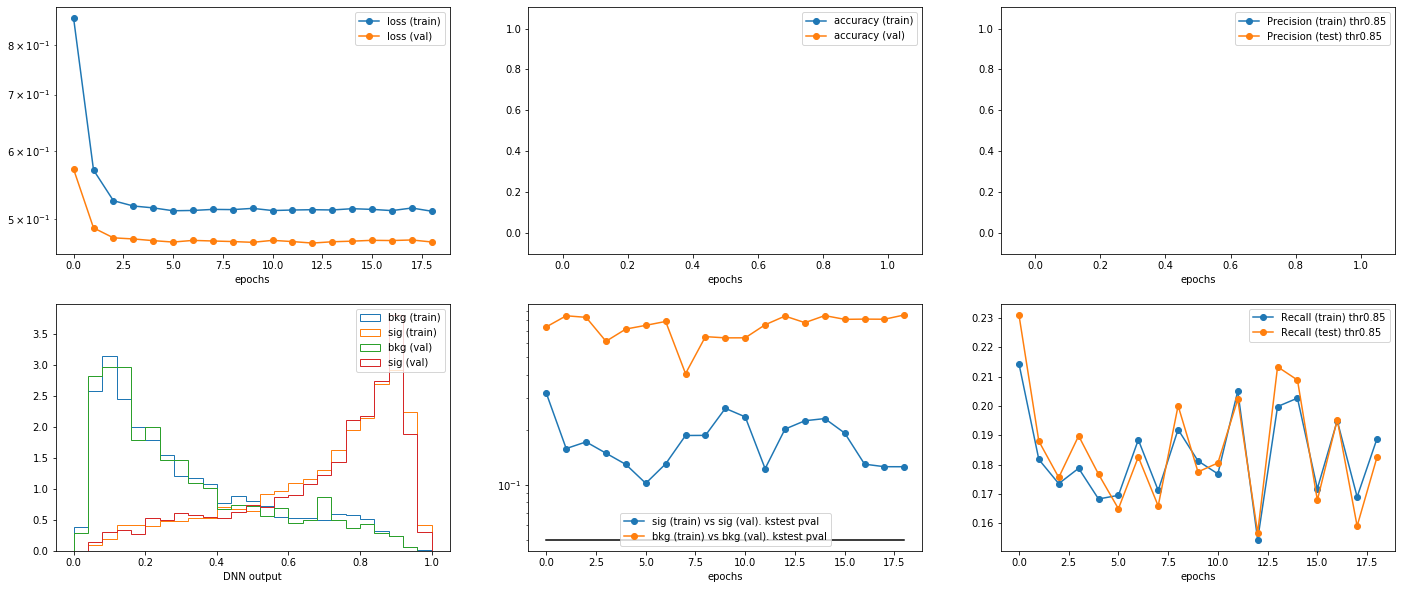

Epoch 20/500
1070/1995 [===============>..............] - ETA: 3s - loss: 0.5164 - binary_accuracy: 0.7844

KeyboardInterrupt: 

In [27]:
history = model.fit_generator(
            training_generator, 
            epochs=config["epochs"],
            steps_per_epoch  = steps_per_epoch_train, 
            validation_data  = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[plot_losses, early_stopping]
            )

config["train_time"] = time.time() - start_time

In [ ]:
config["train_time"]

In [31]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))

ACHTUNG! variables file already existing: old file renamed with '_old'


In [32]:
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

ACHTUNG! model_config_file file already existing: old file renamed with '_old'


In [33]:
# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

In [34]:
# save keras model
model.save(os.path.join(model_dir, "model.h5") )

In [35]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")

W1118 13:23:44.000938 140640609486656 deprecation.py:323] From <ipython-input-35-1725bfe571ff>:52: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W1118 13:23:44.002887 140640609486656 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


## ROC Curves

### ROC with sklearn

In [36]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test)
x, y, thresholds_keras = roc_curve(y_test, y_pred_keras, sample_weight=pesi)

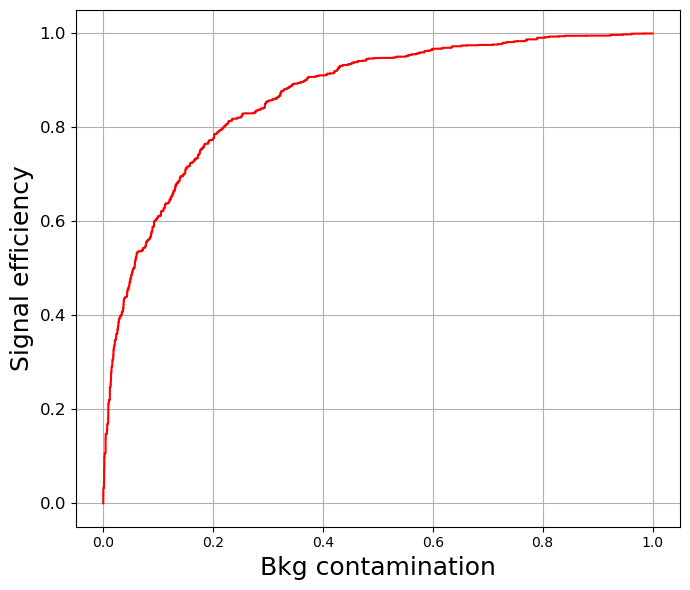

In [37]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

ax1.plot(x,  y, color="red")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

fig.tight_layout()

In [38]:
print(config["model_tag"])
print(x.tolist())
print(y.tolist())

2l_30n_dropout05_l2_batchnorm_relu
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0908851966706007e-05, 1.3992719172681608e-05, 1.3992719172681608e-05, 1.3992719172681608e-05, 1.3992719172681608e-05, 1.3992719172681608e-05, 3.85770841387773e-05, 3.85770841387773e-05, 3.85770841387773e-05, 3.85770841387773e-05, 3.85770841387773e-05, 3.894809108072418e-05, 5.033258671214531e-05, 5.3414623553823946e-05, 5.3414623553823946e-05, 5.3414623553823946e-05, 5.3414623553823946e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.670513023559267e-05, 7.755686392799316e-05, 7.755686392799316e-05, 7.755686392799316e-05, 7.755686392799316e-05, 0.00011868741184314395, 0.00011868741184314395, 0.00012135082613514929, 0.00012135082613514929, 0.0001244624771437423, 0.0001244624771437423, 0.0001244624771437423, 0.0001244624771437423, 0.00021163931455398235, 0.00021163931455398235, 0.00021163931455398235, 0.00021